In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from extra_functions import perspect_transform, color_thresh, rover_coords

In [30]:
# Read in the sample image
image = mpimg.imread('perception_course_sample.jpg')

In [56]:
# Control the variation for multiple runs
# np.random.seed(1)

In [49]:
# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note:Covert to rads, before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in worlds coords
# Position values wil lrange from 20 to 180 to avoid
# the edges in a 200x200 px world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

![](rotation.png)

In [50]:
def rotate_pix(xpix, ypix, yaw):
    # Apply rotation to pixel positions, input yaw angle in degrees
    yaw_rad = yaw * np.pi / 180
    x_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    y_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    return x_rotated, y_rotated

In [51]:
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Perform translation and convert to integer since pixel values cant be float
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    
    return xpix_translated, ypix_translated

In [52]:
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Rotate
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Translate
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    
    return x_pix_world, y_pix_world

### Warping and color thresholding

Define calibration box in source (actual) and destination (desired) coordinates
These source and destination points are defined to warp the image to a grid where each 10x10 pixel square represents 1 square meter

In [53]:
dst_size = 5

# bottom offset to account for bottom of the image not b eing in the position of the rover 
# but a bit in front of it
bottom_offset = 6

source = np.float32([[14,140], [301,140], [200,96], [118,96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0]  - bottom_offset],
                         [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                         [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                         [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                         ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)

# Generate 200x200 px worldmap
worldmap = np.zeros((200,200))
scale = 10

# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, rover_ypos, rover_yaw,
                               worldmap.shape[0], scale)

# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos = ', rover_xpos, 'Ypos = ', rover_ypos, 'Yaw = ', rover_yaw)

Xpos =  [ 93.14475254] Ypos =  [ 55.84724034] Yaw =  [ 226.70515287]


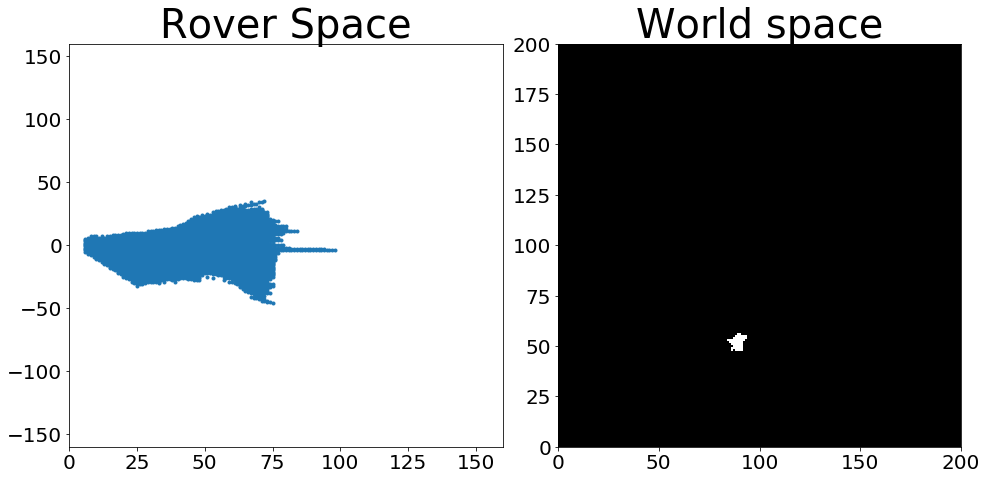

In [54]:
# Plot the map in rover-centric coords
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)

plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show()